<a href="https://colab.research.google.com/github/patrickherbeth/algoritimos_machine_learning/blob/master/BPI_Challenge_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the dataset


---

The dataset is a real-life event log from a Dutch financial institute. The data containg information about loan processes from 2016 up to February 2nd 2017.

The dataset is part of the 13th International Business Process Intelligence Workshop 2017, and can be found on [this](https://www.win.tue.nl/bpi/doku.php?id=2017:challenge) website.


The data is provided in two files:

**The Application event log**. This event log contains all events with the application as the case ID. Any event related to an offer also refers to an OfferID.

**The Offer event log**. This event log contains all events related to offers, with these offers as case ID. For each offer, a corresponding application is available.

For the purpose of this analysis, only the **application event log** was used.



#Dataset Overview

**Importing Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from google.colab import drive

%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Loading the application event log**

In [ ]:
drive.mount('/content/drive')
application_df = pd.read_csv('/content/drive/My Drive/content/BPI_Challenge_2017.csv')

**Viewing the dataset**

In [6]:
application_df.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Columns data types**

In [ ]:
application_df.dtypes

Action                    object
org:resource              object
concept:name              object
EventOrigin               object
EventID                   object
lifecycle:transition      object
time:timestamp            object
case:LoanGoal             object
case:ApplicationType      object
case:concept:name         object
case:RequestedAmount     float64
FirstWithdrawalAmount    float64
NumberOfTerms            float64
Accepted                  object
MonthlyCost              float64
Selected                  object
CreditScore              float64
OfferedAmount            float64
OfferID                   object
dtype: object

In [ ]:
application_df.describe()

,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,MonthlyCost,CreditScore,OfferedAmount
count,1.202267e+06,42995.000000,42995.000000,42995.000000,42995.000000,42995.000000
mean,1.675947e+04,8394.338979,83.041982,281.403309,318.645912,18513.719940
std,1.572320e+04,10852.443358,36.386199,192.577735,433.706216,13718.507416
min,0.000000e+00,0.000000,5.000000,43.050000,0.000000,5000.000000
25%,6.000000e+03,0.000000,56.000000,152.820000,0.000000,8800.000000
50%,1.400000e+04,5000.000000,77.000000,244.520000,0.000000,15000.000000
75%,2.300000e+04,12000.000000,120.000000,350.000000,848.000000,25000.000000
max,4.500000e+05,75000.000000,180.000000,6673.830000,1145.000000,75000.000000


# Exploratory Data Analysis

**Question 1 - What is the most frequent loan goal per month in 2016?**

Initialy, we check the most frequents loan goals in general


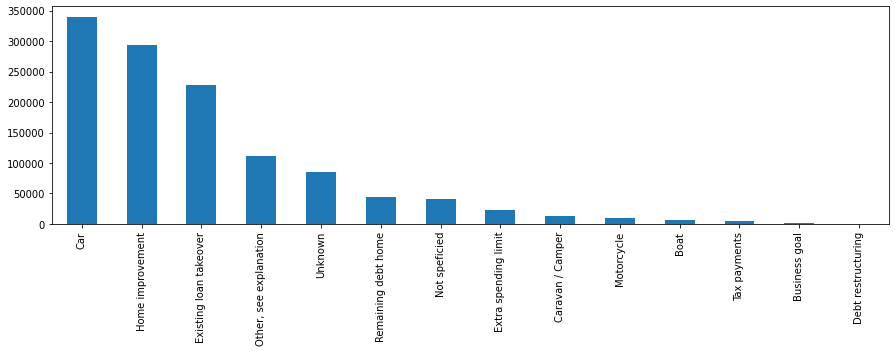

In [ ]:
application_df['case:LoanGoal'].value_counts().plot(figsize=(15, 4), kind='bar')

Now checking the most frequent loan goal per month

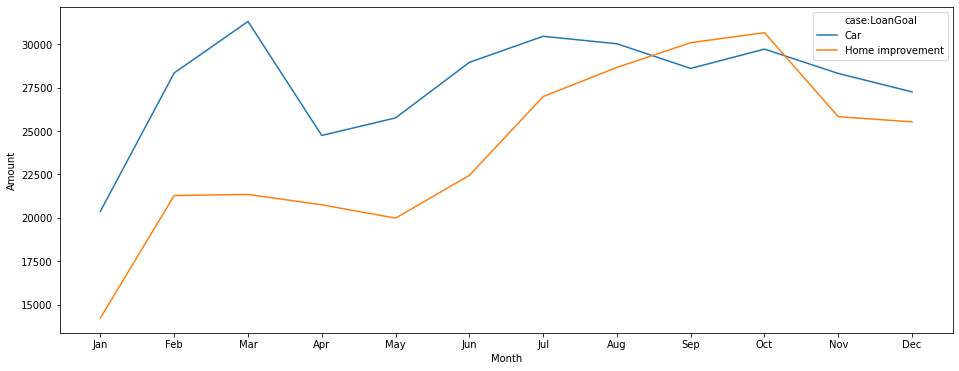

In [7]:
copy_df = application_df[['time:timestamp', 'case:LoanGoal']].copy(deep=True)
copy_df = copy_df[copy_df['time:timestamp'].str[0:4] != '2017']
copy_df['Month'] = copy_df['time:timestamp'].str[5:7].astype('int')

grouped_df = copy_df.groupby(['Month', 'case:LoanGoal']).count()
grouped_df.rename(columns={'time:timestamp': 'Amount', 'case:LoanGoal': 'LoanGoal'}, inplace=True)
grouped_df.sort_values(['Month','Amount'], ascending=False, inplace=True)
grouped_df.reset_index(inplace=True)

most_commons_loan_goal = grouped_df.groupby('Month').nth((0,1))
most_commons_loan_goal = most_commons_loan_goal.reset_index()
most_commons_loan_goal['Month'] = most_commons_loan_goal['Month'].map(lambda Month: calendar.month_abbr[Month])

plt.figure(figsize=(16,6))
sns.lineplot(x='Month', y='Amount', hue='case:LoanGoal', hue_order=['Car', 'Home improvement'], sort= False, markers=True, data=most_commons_loan_goal)

As expected from the first visualization, the loans that have the objetive related to "Car" are the most frequent in general. However, the loans related to "Home Improvement" also have a high freqquency, being the second most frequent in most of the months. 

There is a notable increase of the loans related with "Home improvement" begining in May, and in September and October the "Home improvement" loan goals are highter than the ones related to "Car". But after october this frequency starts to decrease, and the loans related to "Car" start to be the most frequent again.

**Question 2 - What is the mean of the loan requested amount for each of the loan goals?**

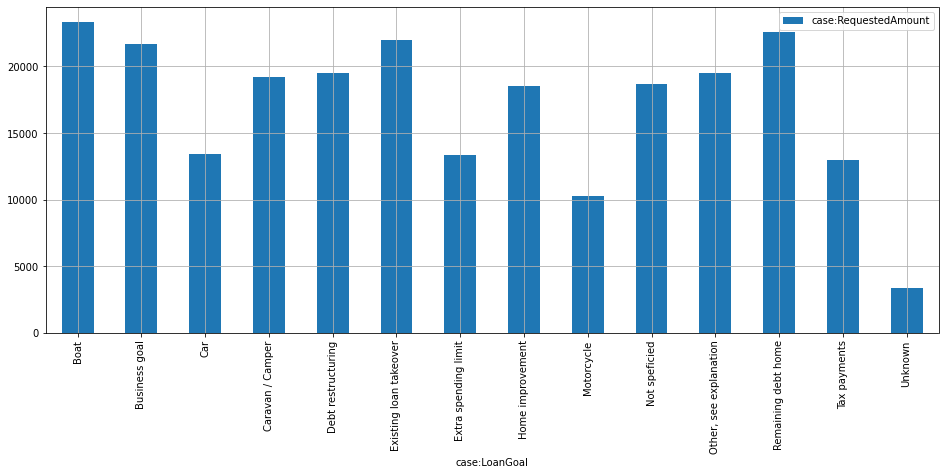

In [8]:
base_media = application_df.groupby(["case:LoanGoal"]).mean()[["case:RequestedAmount"]]

base_media.plot.bar(figsize=(16, 6), grid=True)

#Predictive Analysis

**Question 1 - Predicting the offered amount in a loan process (Regression)**

Checking the offeredAmount column distribution

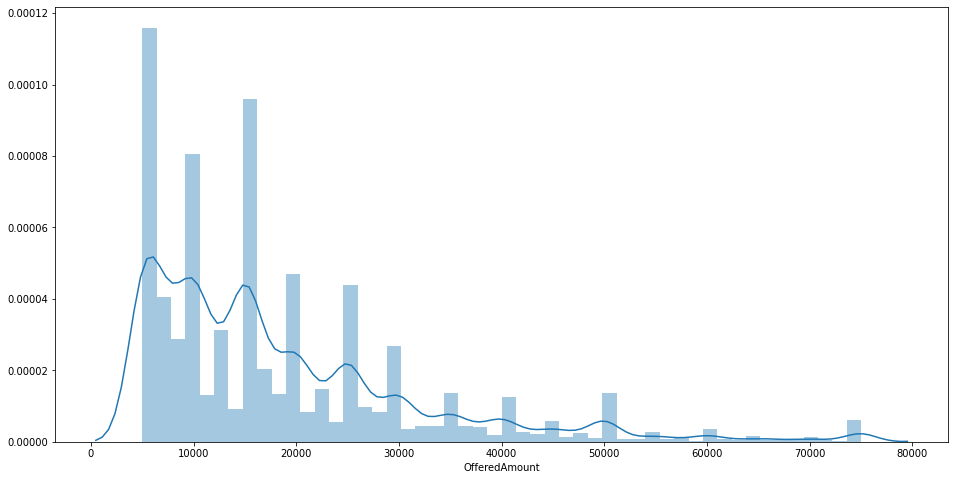

In [9]:
plt.figure(figsize=(16, 8))
plt.tight_layout()
sns.distplot(application_df['OfferedAmount'])

Selecting features

In [10]:
copy_df = application_df[['case:LoanGoal', 'case:RequestedAmount',
                          'case:ApplicationType', 'OfferedAmount']].copy(deep=True)
copy_df.rename(columns={'case:LoanGoal': 'LoanGoal', 'case:RequestedAmount': 'RequestedAmount',
                        'case:ApplicationType': 'ApplicationType'}, inplace=True)

Applying One-Hot Enconding to categorical features

In [11]:
## enconding LoanGoal column
encoder = OneHotEncoder()
encoded_df_loan_goal = pd.DataFrame(encoder.fit_transform(copy_df[['LoanGoal']]).toarray())
encoded_df_loan_goal.columns = encoder.get_feature_names(['LoanGoal'])

# enconding ApplicationType column
encoded_df_app_type = pd.DataFrame(encoder.fit_transform(copy_df[['ApplicationType']]).toarray())
encoded_df_app_type.columns = encoder.get_feature_names(['ApplicationType'])

# removing original categorical columns
copy_df.drop(['LoanGoal', 'ApplicationType'], axis = 1, inplace = True)

# concating the generated DataFrames with the original
copy_df = pd.concat([copy_df, encoded_df_loan_goal, encoded_df_app_type], axis = 1)

copy_df.dropna(inplace=True)

Splitting data in traind and test

In [13]:
x = copy_df[['RequestedAmount', 'LoanGoal_Boat',
       'LoanGoal_Business goal', 'LoanGoal_Car', 'LoanGoal_Caravan / Camper',
       'LoanGoal_Debt restructuring', 'LoanGoal_Existing loan takeover',
       'LoanGoal_Extra spending limit', 'LoanGoal_Home improvement',
       'LoanGoal_Motorcycle', 'LoanGoal_Not speficied',
       'LoanGoal_Other, see explanation', 'LoanGoal_Remaining debt home',
       'LoanGoal_Tax payments', 'LoanGoal_Unknown',
       'ApplicationType_Limit raise', 'ApplicationType_New credit']].values

y = copy_df['OfferedAmount'].values

#splitting data in train and test (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

Training the Linear Regression Model

In [14]:
#training the model
regressor = LinearRegression()  
regressor.fit(x_train, y_train)

#prediction on test data
y_pred = regressor.predict(x_test)

Checking the diff between predction and actual values

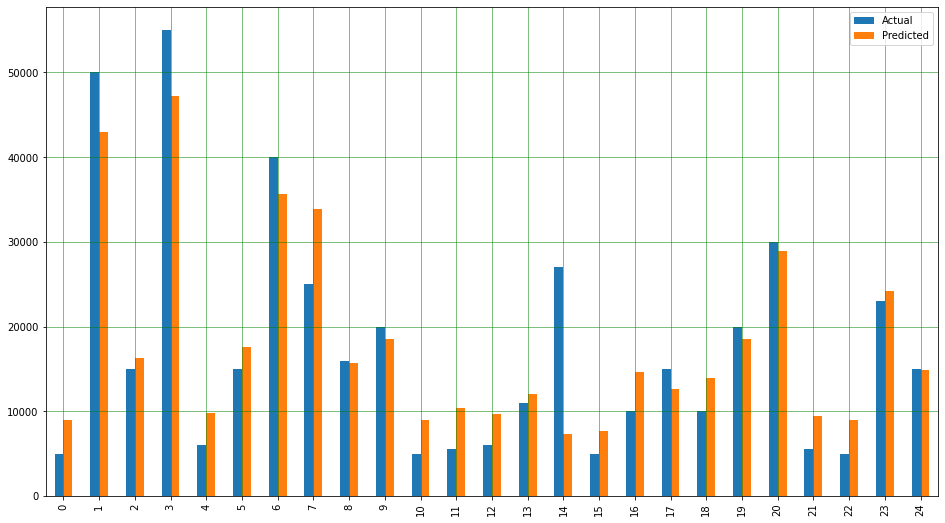

Mean Absolute Error: 4649.121115333006
Root Mean Squared Error: 9278.063887789107


In [15]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)

# Plotting chart with the diff between the predction and actual values
df1.plot(kind='bar',figsize=(16,9))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Calculating some metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [18]:
df1

,Actual,Predicted
0,5000.0,9024.068621
1,50000.0,42929.975440
2,15000.0,16236.823018
3,55000.0,47243.401262
4,6000.0,9747.548999
5,15000.0,17608.162207
6,40000.0,35695.171659
7,25000.0,33886.470714
8,16000.0,15648.913463
9,20000.0,18542.834975


**Question 2 - Predict which applications will receive an offer (Classification)**

In [17]:
# getting the registers of applications that contain A_Pending in their event log 
accepted_loans = application_df[application_df['concept:name'] == 'A_Pending']
accpeteds_application_names = accepted_loans['case:concept:name'].unique()

# creating new column indicating if the application loan was successfull or not
application_df['AcceptedLoan'] = application_df['case:concept:name'].isin(accpeteds_application_names).astype(int)
application_df

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,AcceptedLoan
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1580299144,0


In [18]:
copy_df = application_df[['case:RequestedAmount', 'case:LoanGoal', 'case:ApplicationType', 'AcceptedLoan', 'Selected', 'Accepted', 'CreditScore']].copy(deep=True)

copy_df.dropna(inplace=True)

copy_df.drop_duplicates(inplace=True)

x = copy_df[['case:RequestedAmount', 'CreditScore']].values
y = copy_df['AcceptedLoan'].values

copy_df

,case:RequestedAmount,case:LoanGoal,case:ApplicationType,AcceptedLoan,Selected,Accepted,CreditScore
9,20000.0,Existing loan takeover,New credit,1,True,True,979.0
50,10000.0,Home improvement,New credit,0,False,False,0.0
79,15000.0,Home improvement,New credit,1,False,True,0.0
87,15000.0,Home improvement,New credit,1,True,True,1059.0
135,5000.0,Car,New credit,1,False,False,0.0
...,...,...,...,...,...,...,...
1201901,25000.0,Not speficied,New credit,1,True,True,903.0
1202007,16000.0,Car,New credit,1,True,True,941.0
1202075,5000.0,Car,New credit,1,True,True,852.0
1202148,10000.0,Home improvement,New credit,1,True,True,854.0


In [19]:
#splitting data in train and test sets (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [20]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

#Train the model using 
clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)

print('Accuracy on training set: {:.2f}'
     .format(clf.score(x_train, y_train)))
print('Accuracy on test set: {:.2f}'
     .format(clf.score(x_test, y_test)))

Accuracy on training set: 0.91
Accuracy on test set: 0.88



Precision, Recall result and Precision-Recall average

Precision score: 0.79
Recall score: 0.86
Average precision-recall score: 0.95


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.95')

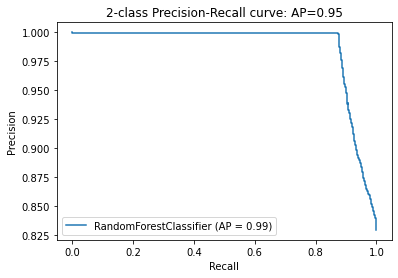

In [36]:
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

average_precision = average_precision_score(y_test, y_pred)

print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

Text(0.5, 1.0, 'Feature Importances')

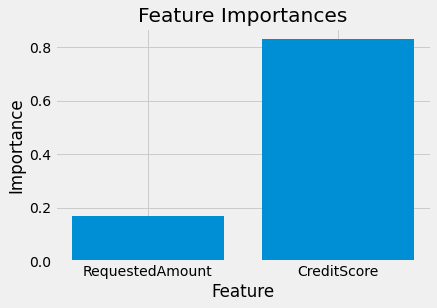

In [ ]:
feature_list = ['RequestedAmount', 'CreditScore']
feature_imp = pd.Series(clf.feature_importances_,index=feature_list)

plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_imp)))
plt.bar(x_values, feature_imp, orientation = 'vertical')
plt.xticks(x_values, feature_list)

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances')